In [25]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance
import pandas as pd
import math
import scipy

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
n_chan = 385
times = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_times.npy').flatten()
clusters = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_clusters.npy').flatten()
mean_wf = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/mean_waveforms.npy")
templates = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/templates.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/neuropixels_dohoung/KS2.5/phy_in/cluster_group.tsv", sep="\t")

In [5]:
times_multi = bd.find_times_multi(times/30000, clusters, np.arange(clusters.max()))

### Switching (firing rate histograms)

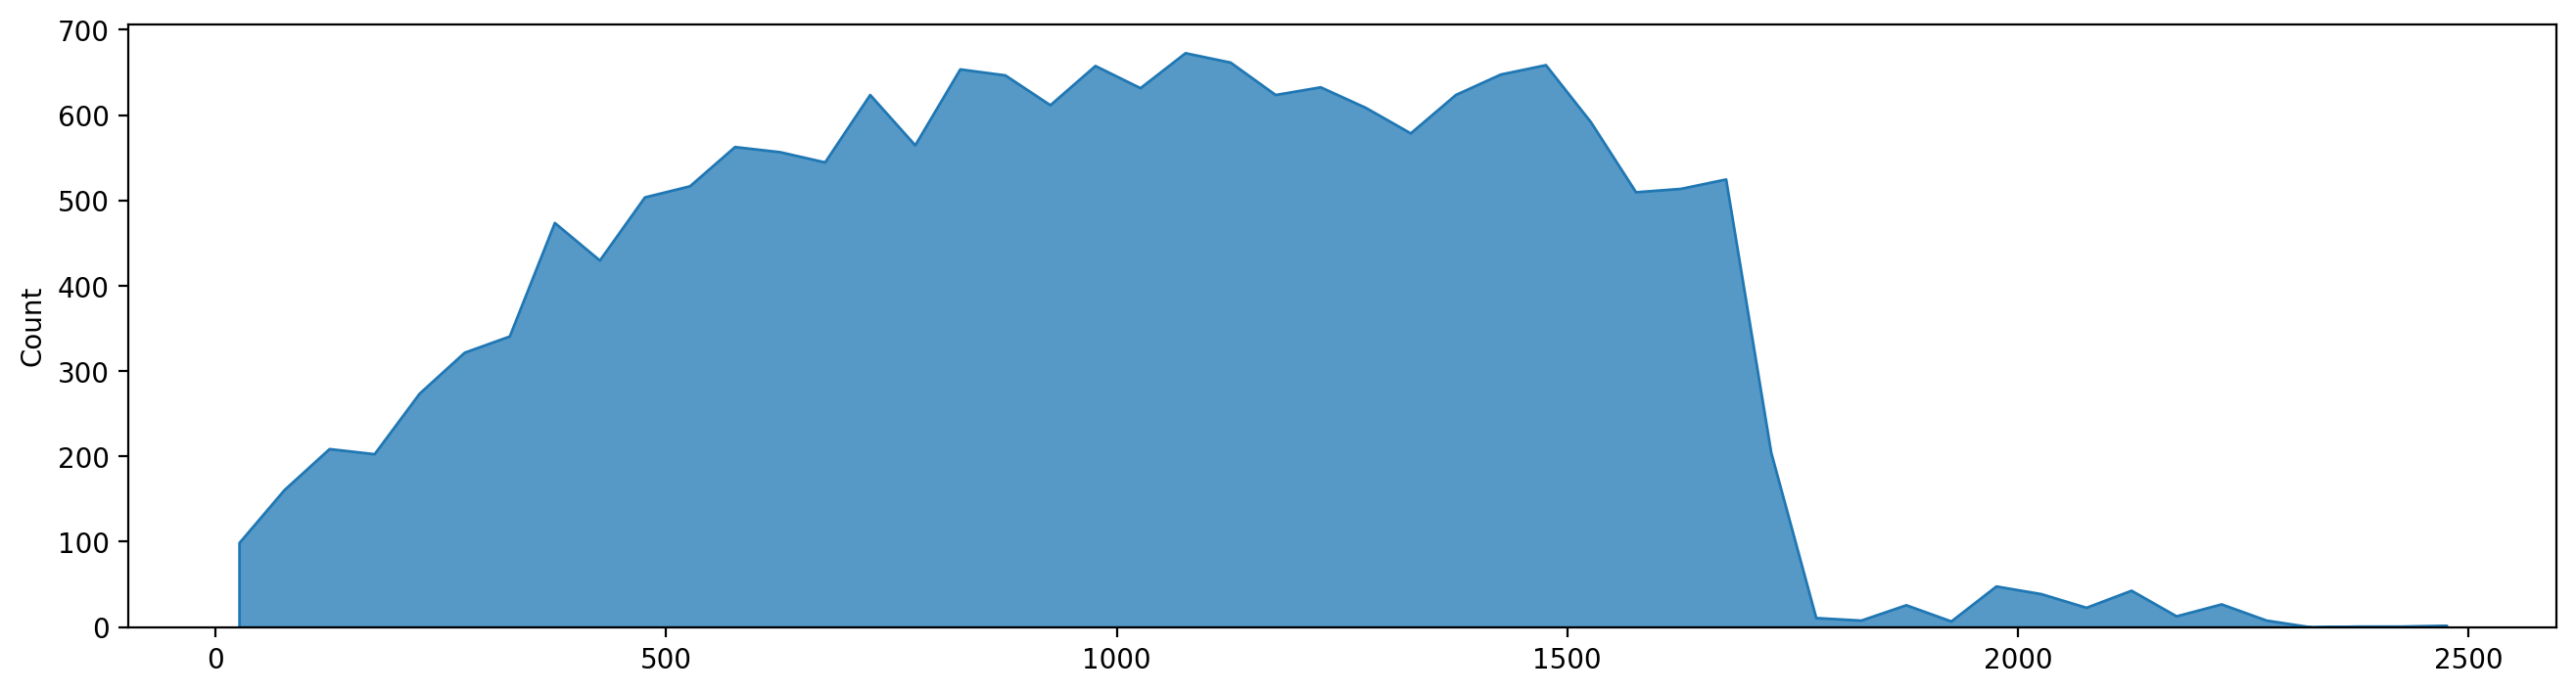

In [68]:
plt.figure(figsize=(16,4))
sns.histplot(times_multi[36], binwidth=50, element="poly");
plt.savefig("../figures/poster/switching/36.svg", transparent=True)

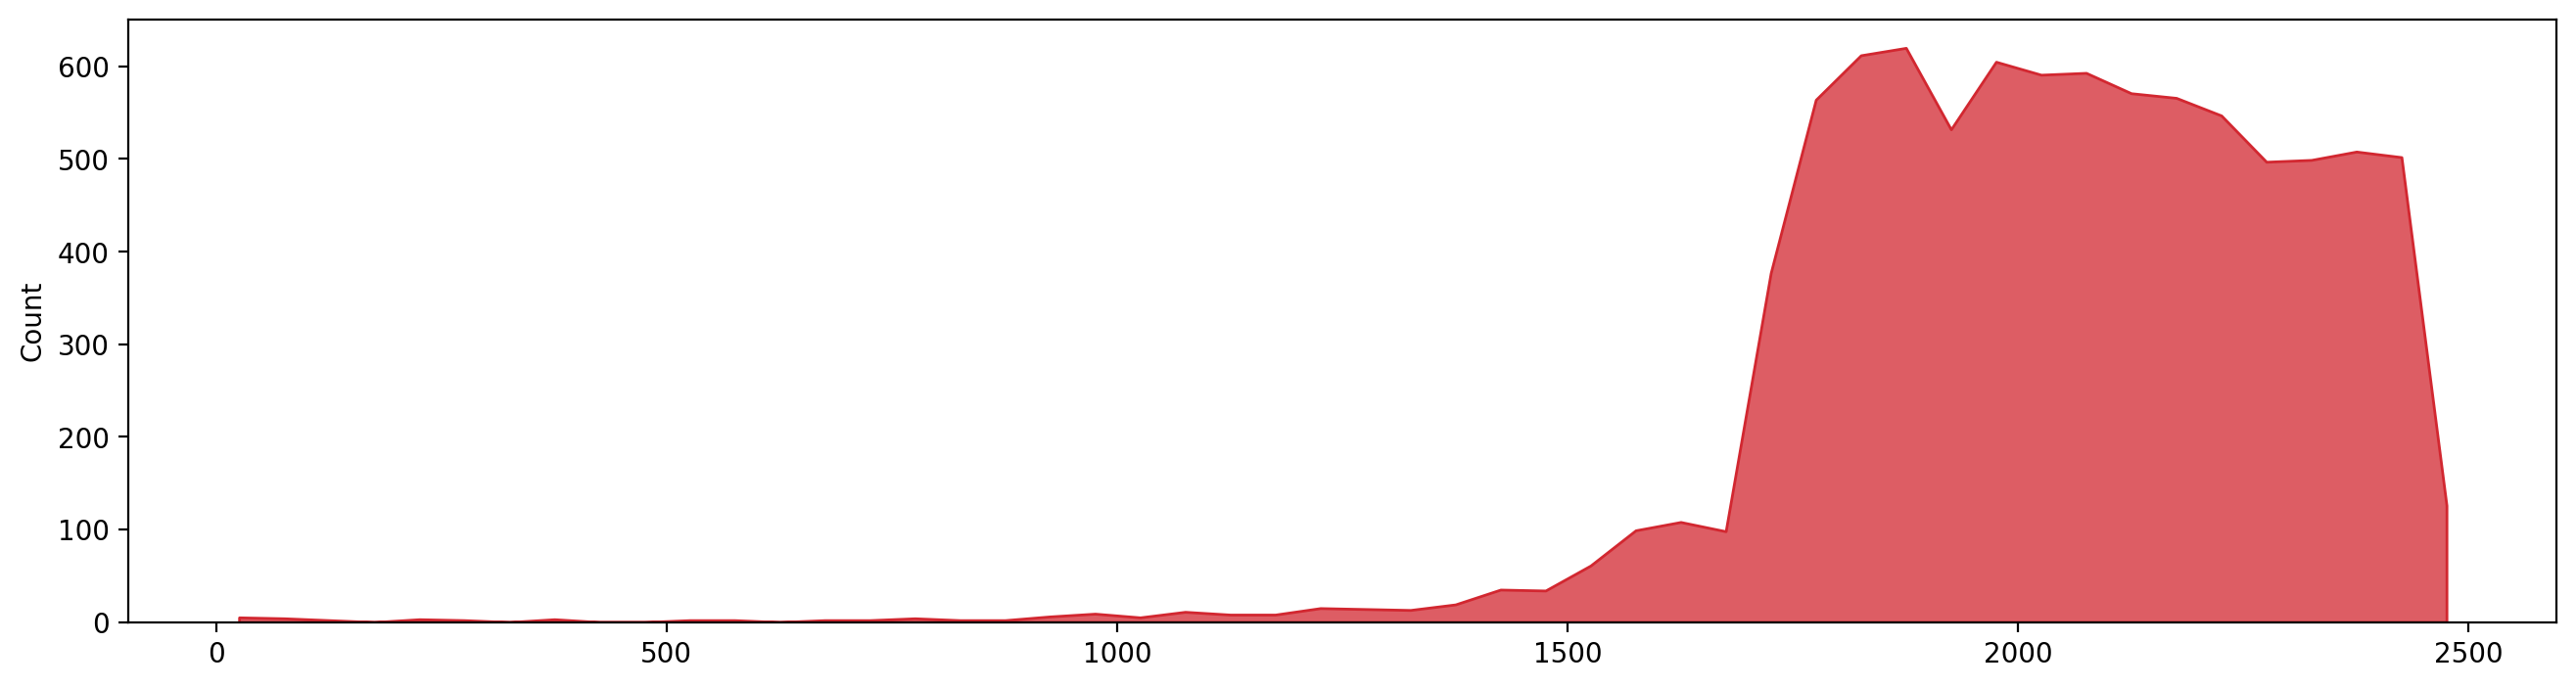

In [69]:
plt.figure(figsize=(16,4))
sns.histplot(times_multi[129], binwidth=50, element="poly", color='#D22730');
plt.savefig("../figures/poster/switching/129.svg", transparent=True)

### Vertical Split

In [39]:
amp51 = templates[51].max(axis=0) - templates[51].min(axis=0)

amp136 = templates[136].max(axis=0) - templates[136].min(axis=0)

ampmean = mean_wf[136].max(axis=1) - mean_wf[136].min(axis=1)
ampmean = mean_wf[51].max(axis=1) - mean_wf[51].min(axis=1)

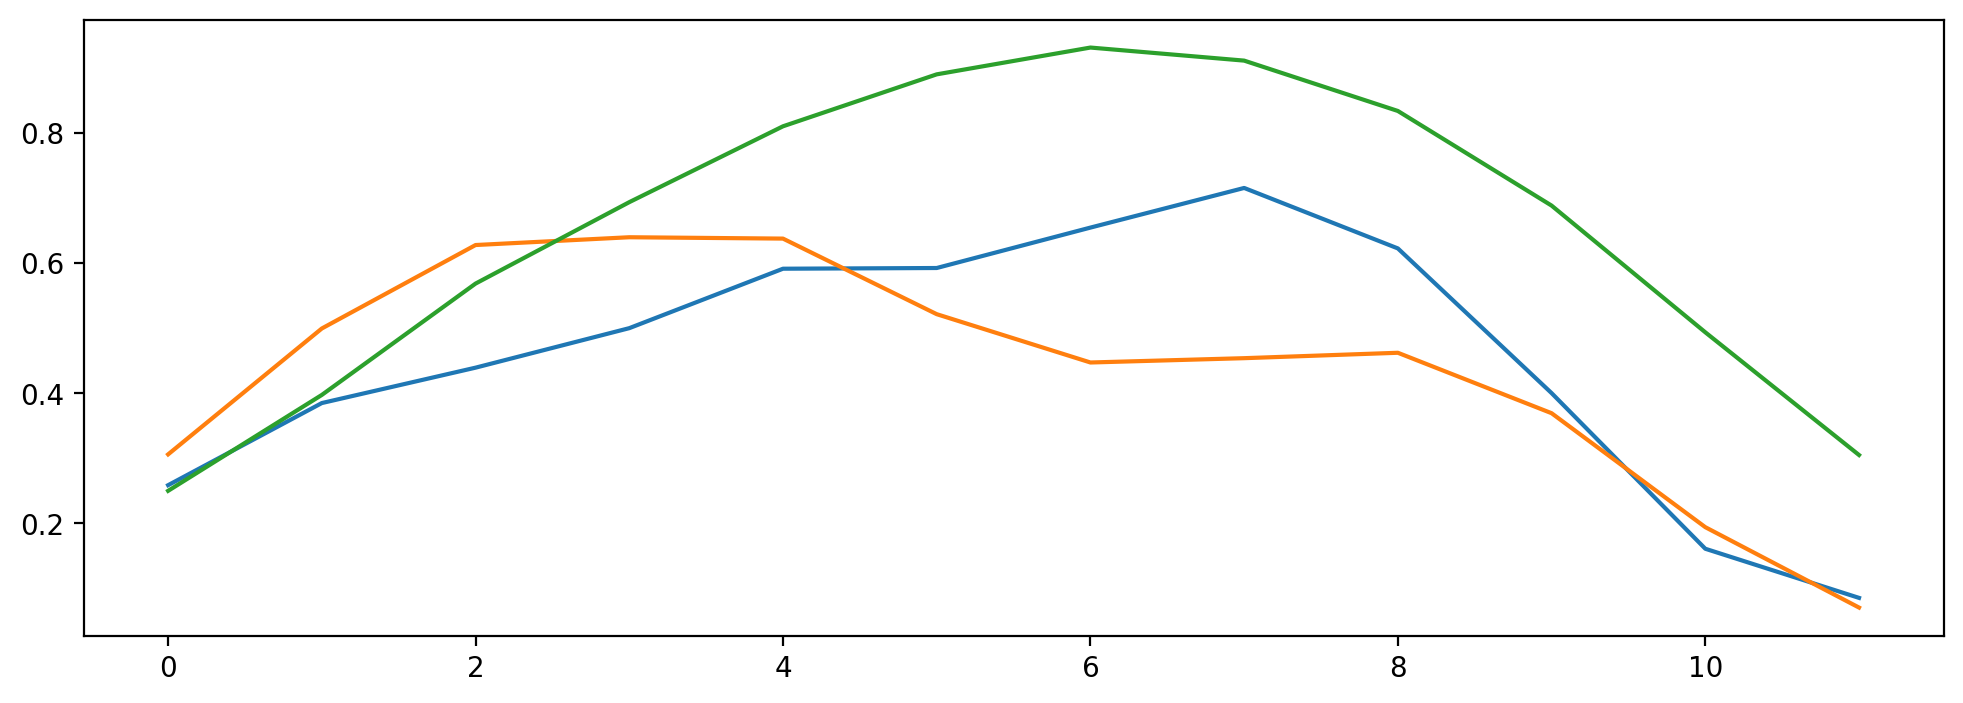

In [47]:
plt.figure(figsize=(12,4))
plt.plot(np.convolve(amp51[156:179:2], np.ones(3), 'same'));
plt.plot(np.convolve(amp136[156:179:2], np.ones(3), 'same'))
plt.plot(np.convolve(ampmean[156:179:2]/250, np.ones(5), 'same'))
plt.savefig("../figures/poster/vertical_split.svg", transparent=True)

In [17]:
np.ma.average()

0.15436436

### xcorr figure

In [48]:
t36 = times_multi[36]
t129 = times_multi[129]

ccg, _ = bd.x_correlogram(t36, t129)

In [78]:
dist = []
unif = []
for i in range(ccg.shape[0]):
    unif.append(i)
    for j in range(int(ccg[i])):
        dist.append(i)

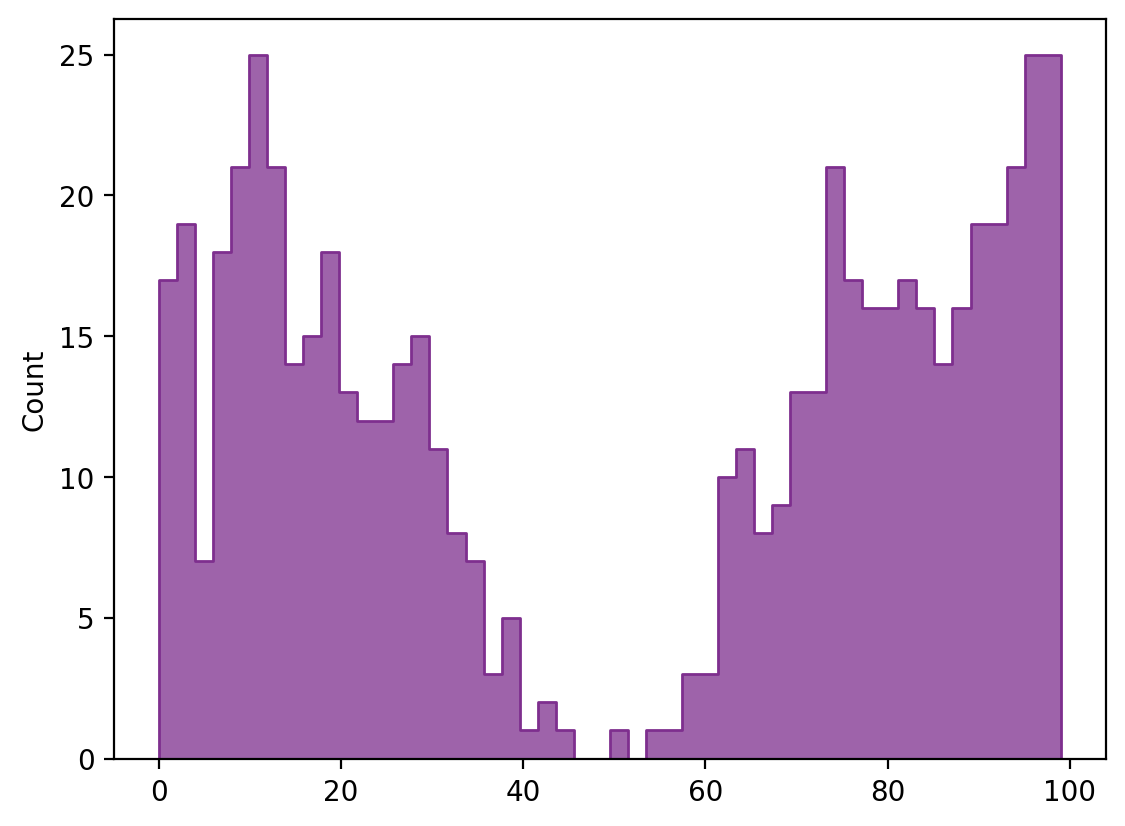

In [74]:
sns.histplot(dist, bins=50, element="step", color="#7e2f8eff");
plt.savefig("../figures/poster/ccg.svg", transparent=True)

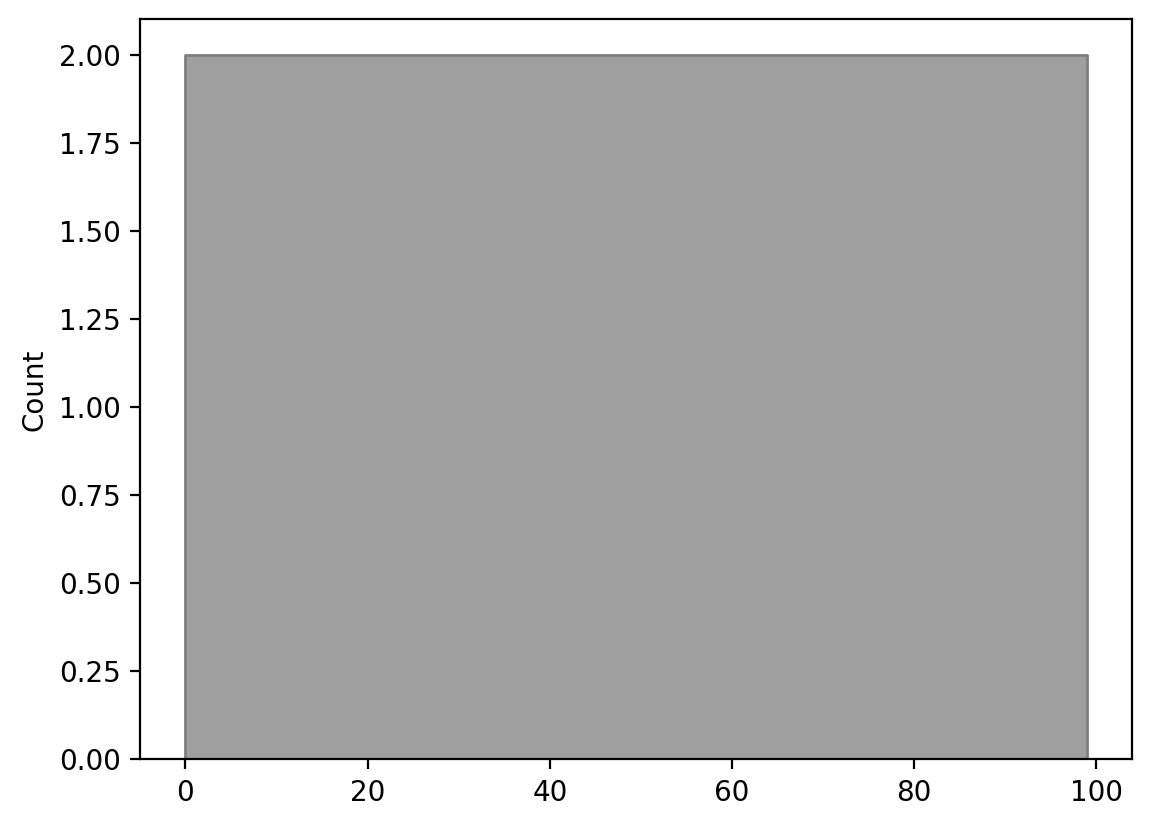

In [80]:
sns.histplot(unif, bins=50, element="step", color="#7f7f7f");
plt.savefig("../figures/poster/unif_ccg.svg", transparent=True)

### refractory period figure

In [82]:
ref_pen = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/automerge/ref_pen.npy")

In [85]:
np.unravel_index(np.argmax(ref_pen), ref_pen.shape)

(27, 124)

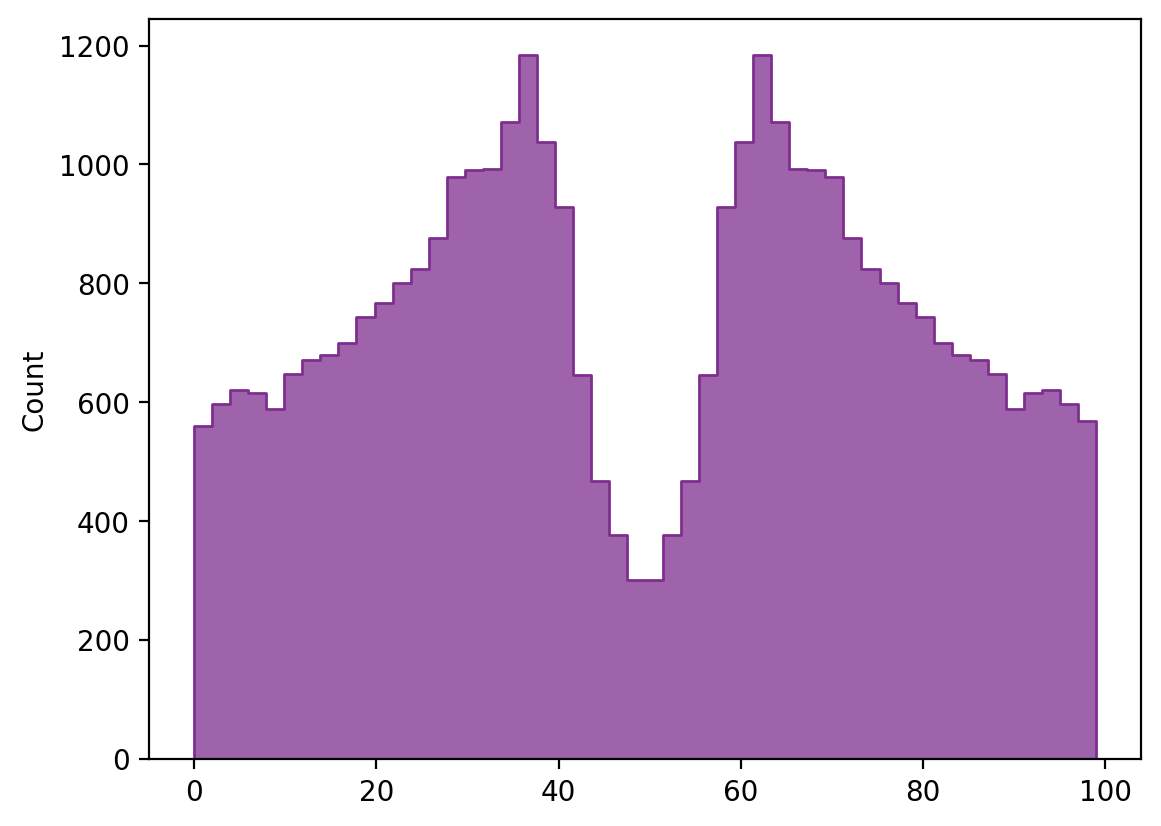

In [97]:
t27 = times_multi[27]
t124 = times_multi[124]

merged = np.sort(np.hstack((t27,t124)))
merge_acg = bd.auto_correlogram(merged, window_size=.1)

dist = []
for i in range(merge_acg.shape[0]):
    for j in range(int(merge_acg[i])):
        dist.append(i)
        
sns.histplot(dist, bins=50, element="step", color="#7e2f8eff");
plt.savefig("../figures/poster/merge_ccg.svg", transparent=True)

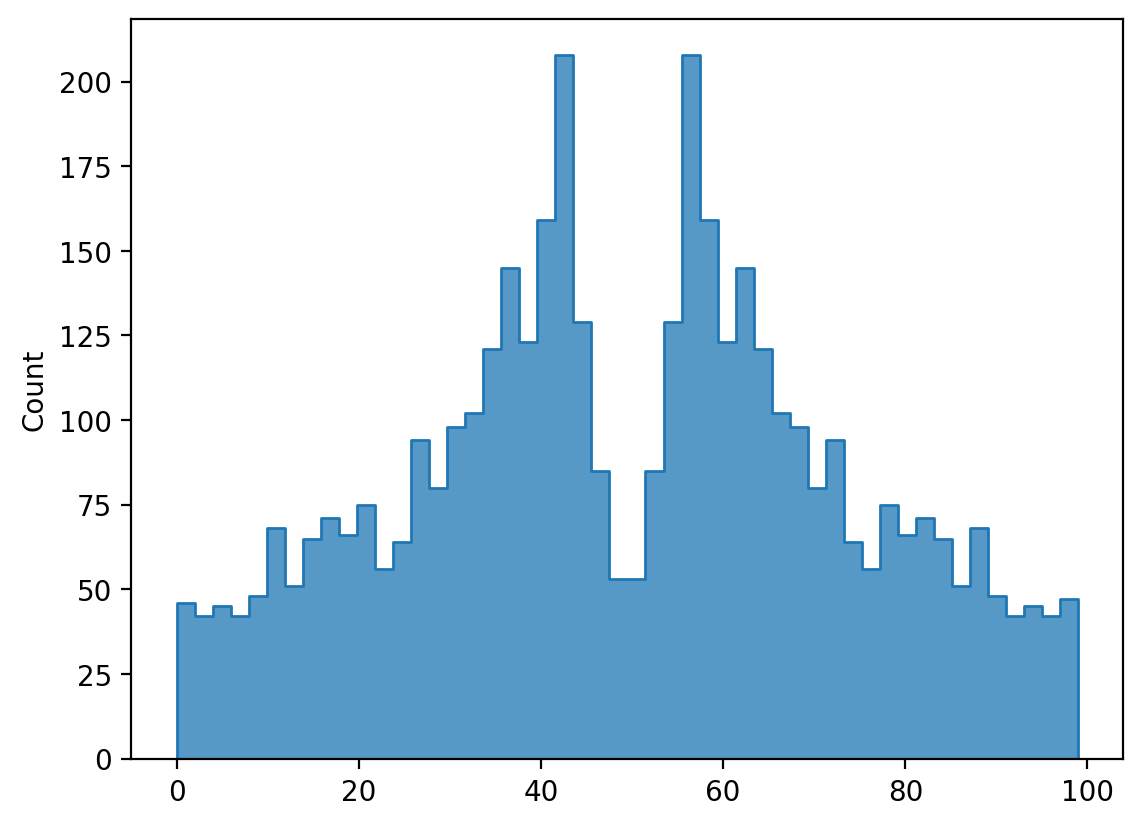

In [101]:
acg1 = bd.auto_correlogram(t27, window_size=.1)

dist = []
for i in range(merge_acg.shape[0]):
    for j in range(int(acg1[i])):
        dist.append(i)
        
sns.histplot(dist, bins=50, element="step", color="#1f77b4ff");
plt.savefig("../figures/poster/acg1.svg", transparent=True)

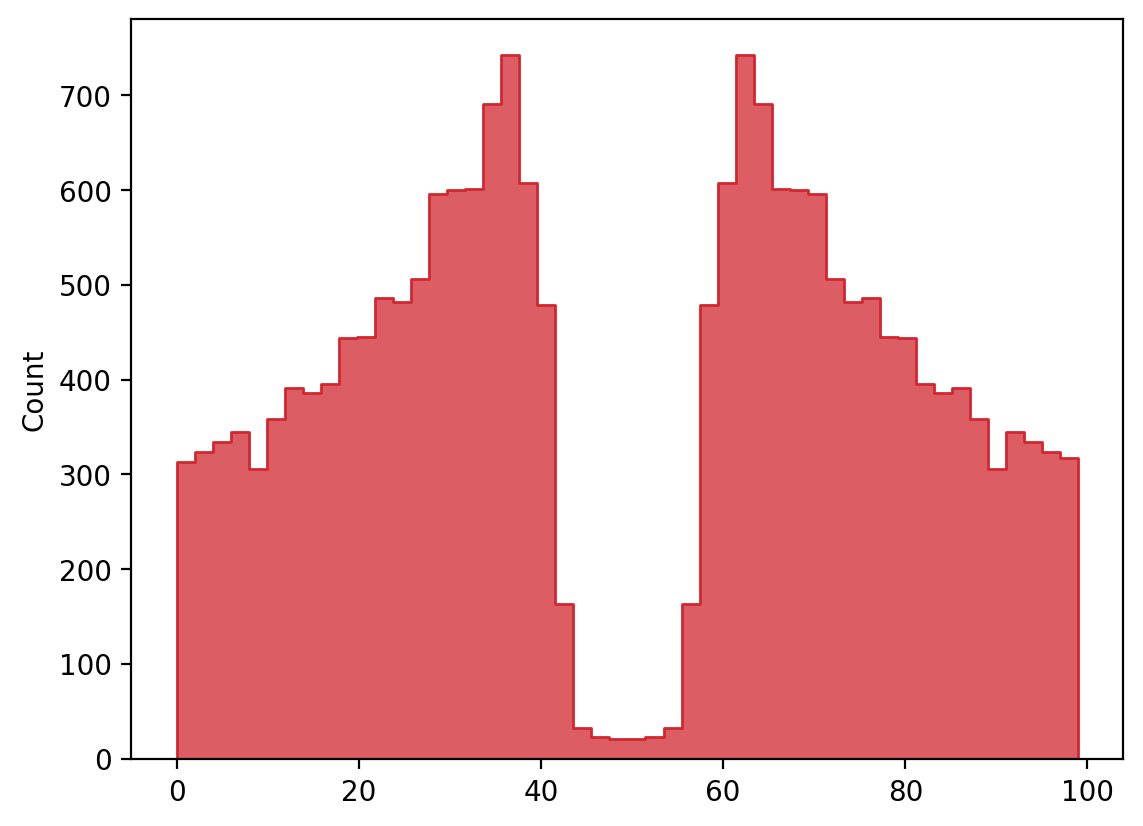

In [102]:
acg2 = bd.auto_correlogram(t124, window_size=.1)

dist = []
for i in range(merge_acg.shape[0]):
    for j in range(int(acg2[i])):
        dist.append(i)
        
sns.histplot(dist, bins=50, element="step", color="#d22730ff");
plt.savefig("../figures/poster/acg2.svg", transparent=True)

### Merging improves burst detection

In [104]:
bursts_74 = pd.read_csv('./burst_dat/bursts_74.csv')[["level","start","end"]].to_numpy(dtype='float64')
bursts_74[:,1] = bursts_74[:,1]/30000
bursts_74[:,2] = bursts_74[:,2]/30000

bursts_79 = pd.read_csv('./burst_dat/bursts_79.csv')[["level","start","end"]].to_numpy(dtype='float64')
bursts_79[:,1] = bursts_79[:,1]/30000
bursts_79[:,2] = bursts_79[:,2]/30000

bursts_merged_74_79 = pd.read_csv('./burst_dat/bursts_merged_74_79.csv')[["level","start","end"]].to_numpy(dtype='float64')
bursts_merged_74_79[:,1] = bursts_merged_74_79[:,1]/30000
bursts_merged_74_79[:,2] = bursts_merged_74_79[:,2]/30000

In [117]:
start = 827
end = 830

t_74 = np.array(bd.find_times(times, clusters, 74))/30000
t_79 = np.array(bd.find_times(times, clusters, 79))/30000
b_in_74 = bursts_74[(bursts_74[:,1] > start) & (bursts_74[:,1] < end)]
b_in_79 = bursts_79[(bursts_79[:,1] > start) & (bursts_79[:,1] < end)]
b_in_merged = bursts_merged_74_79[(bursts_merged_74_79[:,1] > start) & (bursts_merged_74_79[:,1] < end)]

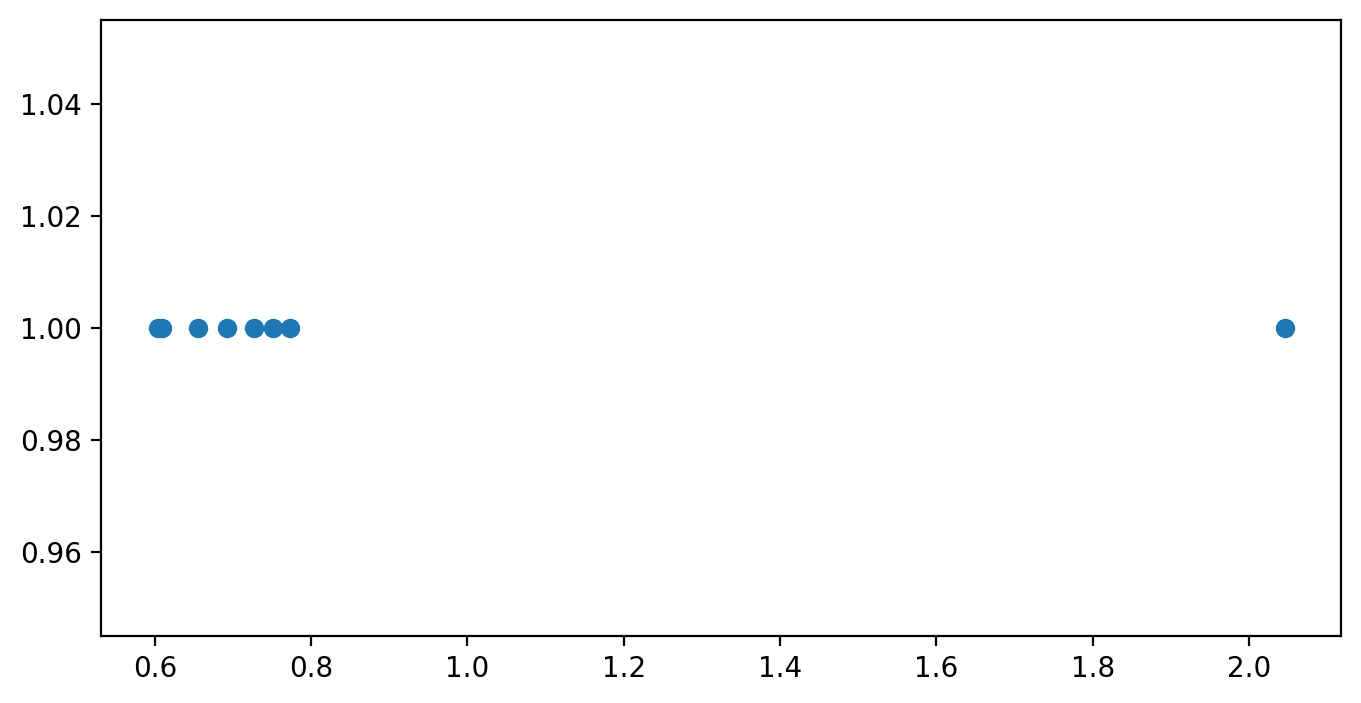

In [119]:
plt.figure(figsize=(8,4))
plt.scatter(t_74[(t_74 > start) & (t_74<end)]-start, np.ones_like(t_74[(t_74>start) & (t_74<end)]), color = "#1f77b4");
plt.savefig("../figures/poster/bd_postmerge_1.svg", transparent=True)

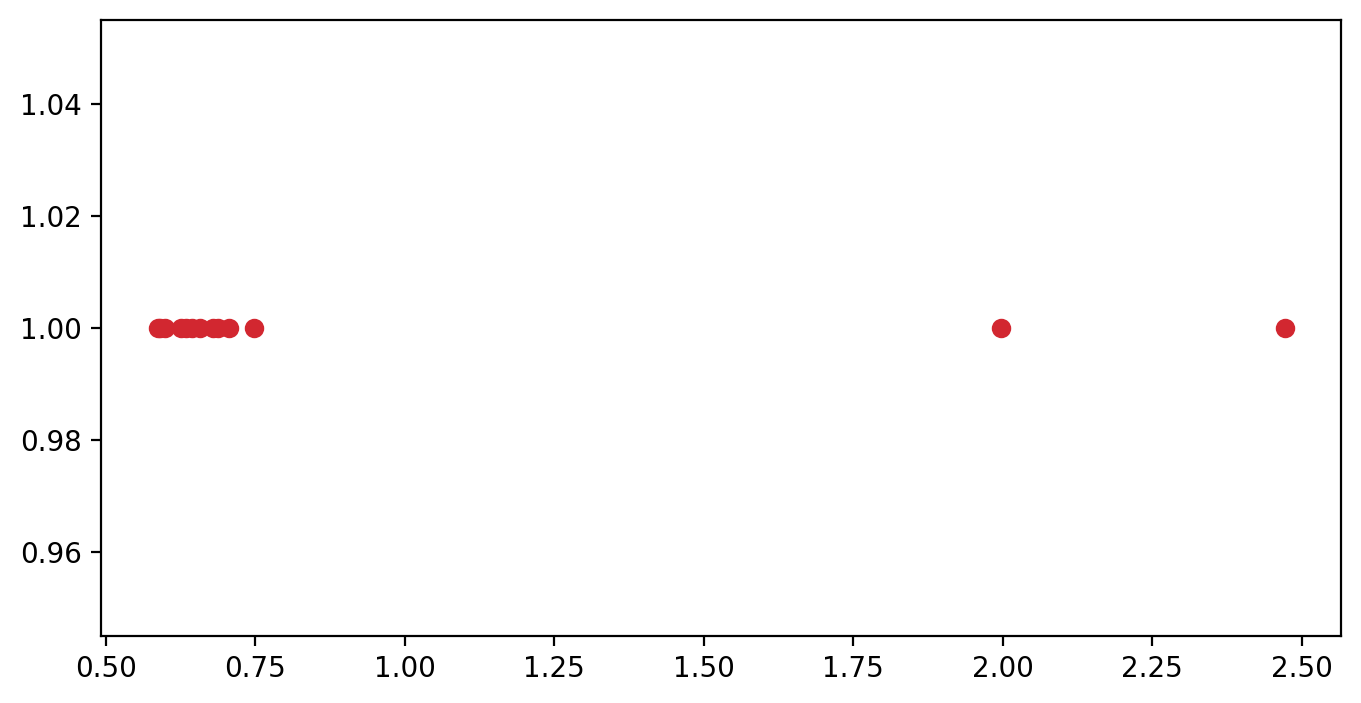

In [120]:
plt.figure(figsize=(8,4))
plt.scatter(t_79[(t_79 > start) & (t_79<end)]-start, np.ones_like(t_79[(t_79>start) & (t_79<end)]), color="#d22730")
plt.savefig("../figures/poster/bd_postmerge_2.svg", transparent=True)

In [121]:
start = 830.7
end = 832.3

t_74 = np.array(bd.find_times(times, clusters, 74))/30000
t_79 = np.array(bd.find_times(times, clusters, 79))/30000
b_in_74 = bursts_74[(bursts_74[:,1] > start) & (bursts_74[:,1] < end)]
b_in_79 = bursts_79[(bursts_79[:,1] > start) & (bursts_79[:,1] < end)]
b_in_merged = bursts_merged_74_79[(bursts_merged_74_79[:,1] > start) & (bursts_merged_74_79[:,1] < end)]

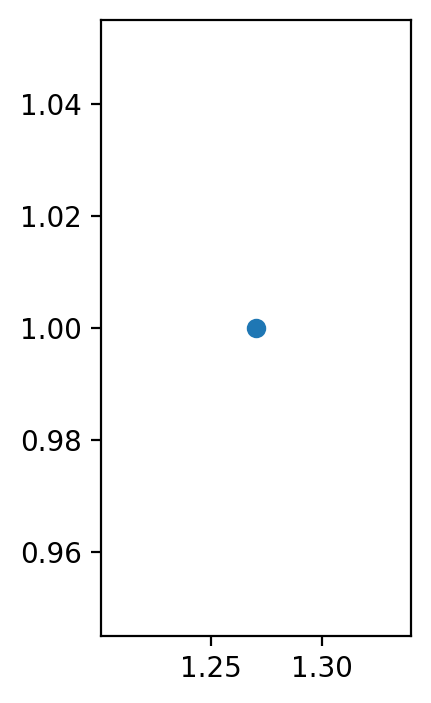

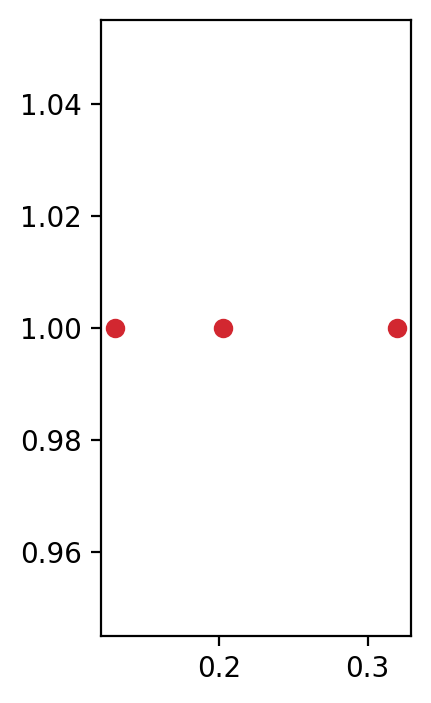

In [125]:
plt.figure(figsize=(2,4))
plt.scatter(t_74[(t_74 > start) & (t_74<end)]-start, np.ones_like(t_74[(t_74>start) & (t_74<end)]), color = "#1f77b4");
plt.savefig("../figures/poster/bd_postmerge_3.svg", transparent=True);

plt.figure(figsize=(2,4))
plt.scatter(t_79[(t_79 > start) & (t_79<end)]-start, np.ones_like(t_79[(t_79>start) & (t_79<end)]), color="#d22730")
plt.savefig("../figures/poster/bd_postmerge_4.svg", transparent=True)